In [21]:
%reset -f

In [22]:
%pwd

'C:\\Users\\andre'

In [23]:
%%javascript
document.addEventListener('keydown', function(e) {
  if (e.key === 'F12') {
    e.preventDefault()
    if (document.fullscreenElement) {
      document.exitFullscreen();
    } else {
      document.documentElement.requestFullscreen();
    }
  }
});


<IPython.core.display.Javascript object>

### Imports and inputs

In [25]:
%reset -f
import pandas as pd
import arcpy
import os
from IPython.display import display

baseDIR = r'C:\Users\andre\Documents\ArcGIS\Projects'
myProject = 'MyProject'
projDIR = r'{}\{}'.format(baseDIR, myProject)
dataDIR = r'{}\{}\Data'.format(baseDIR, myProject)
gdbDIR = r'{}\{}\{}.gdb'.format(baseDIR, myProject, myProject)

arcpy.env.overwriteOutput = True

if os.path.exists(os.path.join(projDIR, 'schema.ini')):
  os.remove(os.path.join(projDIR, 'schema.ini'))

for f in os.listdir(projDIR):
  if 'RasterToNetCD' in f:
    os.remove(os.path.join(projDIR, f))

arcpy.management.Delete(os.path.join(gdbDIR, 'clip_raster'))
arcpy.management.Delete(os.path.join(gdbDIR, 'NoData_Composite'))
arcpy.management.Delete(os.path.join(gdbDIR, 'Filled_Composite'))
arcpy.management.Delete(os.path.join(gdbDIR, 'RawIsoCluster'))
arcpy.management.Delete(os.path.join(gdbDIR, 'FloatIsoCluster'))
arcpy.management.Delete(os.path.join(gdbDIR, 'BoundaryClean'))
arcpy.management.Delete(os.path.join(gdbDIR, 'RasterToPoint'))
arcpy.management.Delete(os.path.join(gdbDIR, 'ForbsandGrass'))
arcpy.management.Delete(os.path.join(gdbDIR, 'ForbsandGrassN'))
arcpy.management.Delete(os.path.join(gdbDIR, 'us_eco_l3'))
arcpy.management.Delete(os.path.join(gdbDIR, 'us_eco_l4'))
arcpy.management.Delete(os.path.join(gdbDIR, 'us_eco_mlra'))

data_files = os.listdir(dataDIR)

input_string = ';'.join(data_files)
input_list = input_string.split(';')

print('ArcPy imported')

ArcPy imported


### SHAPEFILES: clip_area, us_eco_l3, us_eco_l4. RASTERS: l3 and l4 polygons, latitude.

In [26]:

arcpy.env.workspace = dataDIR

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['CCSM4_1974_2013_consec.tif'],
    input_names=['raster'],
    expression='raster >= 0'
  )
output_raster.save(os.path.join(gdbDIR, 'clip_raster'))

arcpy.env.workspace = gdbDIR

with arcpy.EnvManager(outputZFlag='Disabled', outputMFlag='Disabled'):
  arcpy.conversion.RasterToPolygon(
    in_raster='clip_raster',
    out_polygon_features=os.path.join(gdbDIR, 'clip_shape'),
    simplify='SIMPLIFY',
    raster_field='Value',
    create_multipart_features='SINGLE_OUTER_PART',
    max_vertices_per_feature=None
  )

arcpy.management.Project(
  in_dataset=os.path.join(projDIR, 'us_eco_l4', 'us_eco_l4_no_st.shp'),
  out_dataset='us_eco_l4',
  out_coor_system='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]',
  transform_method='WGS_1984_(ITRF00)_To_NAD_1983',
  in_coor_system='PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-96.0],PARAMETER["Standard_Parallel_1",29.5],PARAMETER["Standard_Parallel_2",45.5],PARAMETER["Latitude_Of_Origin",23.0],UNIT["Meter",1.0]]',
  preserve_shape='NO_PRESERVE_SHAPE',
  max_deviation=None,
  vertical='NO_VERTICAL'
)

arcpy.management.Project(
  in_dataset=os.path.join(projDIR, 'us_eco_l3', 'us_eco_l3.shp'),
  out_dataset='us_eco_l3',
  out_coor_system='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]',
  transform_method='WGS_1984_(ITRF00)_To_NAD_1983',
  in_coor_system='PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-96.0],PARAMETER["Standard_Parallel_1",29.5],PARAMETER["Standard_Parallel_2",45.5],PARAMETER["Latitude_Of_Origin",23.0],UNIT["Meter",1.0]]',
  preserve_shape='NO_PRESERVE_SHAPE',
  max_deviation=None,
  vertical='NO_VERTICAL'
)

arcpy.management.Project(
  in_dataset=os.path.join(projDIR, 'MLRA_52_2022', 'MLRA_52.shp'),
  out_dataset='us_eco_mlra',
  out_coor_system='PROJCRS["WGS_1984_Web_Mercator_Auxiliary_Sphere",BASEGEOGCRS["GCS_WGS_1984",DYNAMIC[FRAMEEPOCH[1990.5],MODEL["AM0-2"]],DATUM["D_WGS_1984",ELLIPSOID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],CS[ellipsoidal,2],AXIS["Latitude (lat)",north,ORDER[1]],AXIS["Longitude (lon)",east,ORDER[2]],ANGLEUNIT["Degree",0.0174532925199433]],CONVERSION["Mercator_Auxiliary_Sphere",METHOD["Mercator_Auxiliary_Sphere"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",0.0],PARAMETER["Standard_Parallel_1",0.0],PARAMETER["Auxiliary_Sphere_Type",0.0]],CS[Cartesian,2],AXIS["Easting (X)",east,ORDER[1]],AXIS["Northing (Y)",north,ORDER[2]],LENGTHUNIT["Meter",1.0],ID["EPSG","3857"]]',
  transform_method=None,
  in_coor_system='GEOGCRS["GCS_WGS_1984",DYNAMIC[FRAMEEPOCH[1990.5],MODEL["AM0-2"]],DATUM["D_WGS_1984",ELLIPSOID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],CS[ellipsoidal,2],AXIS["Latitude (lat)",north,ORDER[1]],AXIS["Longitude (lon)",east,ORDER[2]],ANGLEUNIT["Degree",0.0174532925199433],ID["EPSG","4326"]]',
  preserve_shape='NO_PRESERVE_SHAPE',
  max_deviation=None,
  vertical='NO_VERTICAL'
)

arcpy.analysis.Clip(
  in_features='us_eco_l4',
  clip_features='clip_shape',
  out_feature_class='us_eco_l4_clip',
  cluster_tolerance=None
)

arcpy.analysis.Clip(
  in_features='us_eco_l3',
  clip_features='clip_shape',
  out_feature_class='us_eco_l3_clip',
  cluster_tolerance=None
)

arcpy.analysis.Clip(
  in_features='us_eco_mlra',
  clip_features='clip_shape',
  out_feature_class='us_eco_mlra_clip',
  cluster_tolerance=None
)

arcpy.conversion.PolygonToRaster(
  in_features='us_eco_l3_clip',
  value_field='US_L3CODE',
  out_rasterdataset='us_eco_l3_raster',
  cell_assignment='CELL_CENTER',
  priority_field='NONE',
  cellsize='clip_raster',
  build_rat='BUILD'
)

arcpy.conversion.RasterToPoint(
  in_raster='us_eco_l3_raster',
  out_point_features='RasterToPoint',
  raster_field='Value'
)

arcpy.management.AddXY(
  in_features='RasterToPoint'
)

arcpy.conversion.PointToRaster(
  in_features='RasterToPoint',
  value_field='POINT_Y',
  out_rasterdataset='Latitude',
  cell_assignment='MOST_FREQUENT',
  priority_field='NONE',
  cellsize='clip_raster',
  build_rat='DO_NOT_BUILD'
)


<Result 'C:\\Users\\andre\\Documents\\ArcGIS\\Projects\\MyProject\\MyProject.gdb\\Latitude'>

### Make Extract_Composite multi-band raster

In [5]:
from arcpy.sa import Con

input_list = uncorr_input_list
input_string = uncorr_input_string

input_string = input_string.replace('.tif', "")

arcpy.env.workspace = gdbDIR

for f in input_list:

  raster = arcpy.Raster(os.path.join(dataDIR, f))
    
  with arcpy.EnvManager(scratchWorkspace=gdbDIR):
    out_raster = arcpy.sa.ExtractByMask(
      in_raster=raster,
      in_mask_data='clip_shape',
      extraction_area='INSIDE',
      analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
    )

  ##########
  ##Normalize
  ###

  arcpy.management.CalculateStatistics(out_raster)
  mean_value = arcpy.Raster(out_raster).mean
  sdev_value = arcpy.Raster(out_raster).standardDeviation
  min_value = arcpy.Raster(out_raster).minimum
  max_value = arcpy.Raster(out_raster).maximum
  #out_raster = Con((out_raster <= mean_value + (3*sdev_value)) & (out_raster >= mean_value - (3*sdev_value)), out_raster, mean_value)

  # with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  #   out_raster = arcpy.ia.RasterCalculator(
  #     rasters=[out_raster],
  #     input_names=['raster'],
  #     expression='(raster - {})/({})'.format(mean_value, sdev_value)
  #   )

  with arcpy.EnvManager(scratchWorkspace=gdbDIR):
    out_raster = arcpy.ia.RasterCalculator(
      rasters=[out_raster],
      input_names=['raster'],
      expression='(raster - {})/({} - {})'.format(min_value, max_value, min_value)
    )
    
  out_raster.save(f[:-4])

with arcpy.EnvManager(scratchWorkspace=gdbDIR, extent='MAXOF'):
  arcpy.management.CompositeBands(
    in_rasters=input_string,
    out_raster='CompositeBands'
  )

for f in input_list:
  arcpy.management.Delete(f[:-4])

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  out_raster = arcpy.ia.RasterCalculator(
    rasters=['CompositeBands'],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  out_raster = arcpy.ia.RasterCalculator(
    rasters=[out_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),{},raster)'.format(mean_value)
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.sa.ExtractByMask(
    in_raster=out_raster,
    in_mask_data='clip_shape',
    extraction_area='INSIDE',
    analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
  )
output_raster.save('Extract_Composite')
del output_raster
arcpy.CopyRaster_management('Extract_Composite', os.path.join(projDIR, 'Extract_Composite.tif'))

print('DONE')


DONE


### Run principle component tool to get information from output text file

In [14]:

#ZeroOne n=8, Zscore n=12
num_comps = 8

arcpy.env.workspace = gdbDIR

with arcpy.EnvManager(scratchWorkspace=projDIR):
  out_multiband_raster = arcpy.sa.PrincipalComponents(
    in_raster_bands='Extract_Composite',
    number_components=num_comps,
    out_data_file='pca_info.txt'
  )
out_multiband_raster.save(os.path.join(gdbDIR, 'Princip_Composite'))

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['Princip_Composite'],
    input_names=['raster'],
    expression='Con(IsNull(raster),9999,raster)'
  )
output_raster.save(os.path.join(gdbDIR, 'Filled_Composite'))

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.sa.ExtractByMask(
    in_raster='Filled_Composite',
    in_mask_data='clip_shape',
    extraction_area='INSIDE',
    analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
  )
output_raster.save(os.path.join(gdbDIR, 'Princip_Composite'))
del output_raster
arcpy.CopyRaster_management('Princip_Composite', os.path.join(projDIR, 'Princip_Composite.tif'))

print('DONE')


DONE


### Print correlation matrix

In [11]:

#input_list = uncorr_input_list

vif_cutoff = 3

pca_info_path = 'pca_info.txt'


with open(os.path.join(projDIR, pca_info_path)) as f:
  lines = f.readlines()

for i, line in enumerate(lines):
  if 'CORRELATION MATRIX' in line:
    hdr_line_idx = i
    for j, l in enumerate(lines[hdr_line_idx:]):
      if '#  ========' in l:
        ftr_line_idx = hdr_line_idx + j
        break
    break

start_idx = hdr_line_idx + 4
end_idx = ftr_line_idx - 1

corr_m_lines = lines[start_idx:end_idx + 1]

corr_data = []
for l in corr_m_lines:
  row = l.split()
  corr_data.append([float(x) for x in row[1:]])

corr_df = pd.DataFrame(corr_data)

def vif_fn(x):
  if x != 1:
    vif = (1)/(1 - x**2)
  else:
    vif = 0
  return vif

vif_df = corr_df.map(vif_fn)

high_value_mask = vif_df >= vif_cutoff
stacked_mask = high_value_mask.stack()
result = stacked_mask[stacked_mask]

matrix_index_col_list = []
for (index, col), _ in result.items():
  matrix_index_col_list.append([index, col])

index_col_list = []
for l in matrix_index_col_list:
  if l not in index_col_list and l.reverse() not in index_col_list:
    index_col_list.append(l)

print('VIF FACTORS >={}:'.format(vif_cutoff))  
for index, col in index_col_list:
  print(f"Index: {index}, Column: {col}, Value: {vif_df.loc[index, col]}")
  print(input_list[index], input_list[col])


VIF FACTORS >=3:


### Remove multicolinearity from inputs with VIF > 5 EXCEPT FOR DEM_Elev.tif

In [7]:

removal_choices = ['pmomx_1974_2013.tif', 'CCSM4_1974_2013_pet.tif', 'POL_theta_s.tif', 'POL_theta_r.tif', 'RAP_afg.tif', 'RAP_pfg.tif', 'RAP_tre.tif', 'RAP_shr.tif', 'tmean_1974_2013.tif']

uncorr_input_list = []
for l in input_list:
  if l not in removal_choices:
    uncorr_input_list.append(l)

uncorr_input_string = ';'.join(uncorr_input_list)

var_labels = [s[:-4] for s in input_list]
df = pd.DataFrame(data=var_labels, index=list(range(1, len(var_labels)+1)))
print('All Variables:')
display(df)

var_labels = [s[:-4] for s in uncorr_input_list]
df = pd.DataFrame(data=var_labels, index=list(range(1, len(var_labels)+1)))
print('Uncorrelated Variables:')
display(df)

varidx_varlbl_key = df.to_dict()[0]
print(varidx_varlbl_key)


All Variables:


,0
1,accm_1974_2013
2,CCSM4_1974_2013_consec
3,CCSM4_1974_2013_ero
4,CCSM4_1974_2013_ndays
5,CCSM4_1974_2013_pet
6,CCSM4_1974_2013_swe
7,DEM_Elev
8,DEM_Slope
9,pmomn_1974_2013
10,pmomx_1974_2013


Uncorrelated Variables:


,0
1,accm_1974_2013
2,CCSM4_1974_2013_consec
3,CCSM4_1974_2013_ero
4,CCSM4_1974_2013_ndays
5,CCSM4_1974_2013_swe
6,DEM_Elev
7,DEM_Slope
8,pmomn_1974_2013
9,POL_bd
10,POL_clay


{1: 'accm_1974_2013', 2: 'CCSM4_1974_2013_consec', 3: 'CCSM4_1974_2013_ero', 4: 'CCSM4_1974_2013_ndays', 5: 'CCSM4_1974_2013_swe', 6: 'DEM_Elev', 7: 'DEM_Slope', 8: 'pmomn_1974_2013', 9: 'POL_bd', 10: 'POL_clay', 11: 'POL_ksat', 12: 'POL_om', 13: 'POL_ph', 14: 'POL_sand', 15: 'POL_silt', 16: 'RAP_afgNPP', 17: 'RAP_bgr', 18: 'RAP_ltr', 19: 'RAP_pfgNPP', 20: 'RAP_shrNPP', 21: 'RAP_treNPP', 22: 'tmomn_1974_2013', 23: 'tmomx_1974_2013'}


### Remove multicolinearity from inputs with VIF > 3 EXCEPT FOR DEM_Elev.tif

In [26]:
removal_choices = ['tmomx_1974_2013.tif', 'pmomx_1974_2013.tif', 'pmomn_1974_2013.tif', 'CCSM4_1974_2013_swe.tif', 'CCSM4_1974_2013_consec.tif', 'CCSM4_1974_2013_pet.tif', 'POL_theta_s.tif', 'POL_theta_r.tif', 'POL_clay.tif', 'POL_silt.tif', 'RAP_afg.tif', 'RAP_pfg.tif', 'RAP_tre.tif', 'RAP_shr.tif', 'tmean_1974_2013.tif']

uncorr_input_list = []
for l in input_list:
  if l not in removal_choices:
    uncorr_input_list.append(l)

uncorr_input_string = ';'.join(uncorr_input_list)

var_labels = [s[:-4] for s in input_list]
df = pd.DataFrame(data=var_labels, index=list(range(1, len(var_labels)+1)))
print('All Variables:')
display(df)

var_labels = [s[:-4] for s in uncorr_input_list]
df = pd.DataFrame(data=var_labels, index=list(range(1, len(var_labels)+1)))
print('Uncorrelated Variables:')
display(df)

varidx_varlbl_key = df.to_dict()[0]
print(varidx_varlbl_key)


All Variables:


,0
1,accm_1974_2013
2,CCSM4_1974_2013_consec
3,CCSM4_1974_2013_ero
4,CCSM4_1974_2013_ndays
5,CCSM4_1974_2013_pet
6,CCSM4_1974_2013_swe
7,DEM_Elev
8,DEM_Slope
9,pmomn_1974_2013
10,pmomx_1974_2013


Uncorrelated Variables:


,0
1,accm_1974_2013
2,CCSM4_1974_2013_ero
3,CCSM4_1974_2013_ndays
4,DEM_Elev
5,DEM_Slope
6,POL_bd
7,POL_ksat
8,POL_om
9,POL_ph
10,POL_sand


{1: 'accm_1974_2013', 2: 'CCSM4_1974_2013_ero', 3: 'CCSM4_1974_2013_ndays', 4: 'DEM_Elev', 5: 'DEM_Slope', 6: 'POL_bd', 7: 'POL_ksat', 8: 'POL_om', 9: 'POL_ph', 10: 'POL_sand', 11: 'RAP_afgNPP', 12: 'RAP_bgr', 13: 'RAP_ltr', 14: 'RAP_pfgNPP', 15: 'RAP_shrNPP', 16: 'RAP_treNPP', 17: 'tmomn_1974_2013'}


### Iso Cluster using composite as input (Not used)

In [3]:

arcpy.env.workspace = gdbDIR

with arcpy.EnvManager(scratchWorkspace=os.path.join(gdbDIR)):
  output_classified_raster = arcpy.sa.IsoClusterUnsupervisedClassification(
    in_raster_bands='Extract_Composite',
    Number_of_classes=15,
    Minimum_class_size=170,
    Sample_interval=10,
    out_signature_file=os.path.join(projDIR, 'iso_signature.gsg')
  )
output_classified_raster.save('FloatIsoCluster')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  out_raster = arcpy.ia.Int(
    in_raster_or_constant='FloatIsoCluster'
  )
out_raster.save('IsoCluster')
del out_raster
arcpy.CopyRaster_management('IsoCluster', os.path.join(projDIR, 'IsoCluster.tif'))

print('DONE')


DONE


### Iso Cluster using PCA as input and multidimensional raster

In [6]:

import random
threedigits = [str(x) for x in random.sample(range(0, 10), 3)]

arcpy.env.workspace = gdbDIR

arcpy.md.RasterToNetCDF(
  in_raster='Extract_Composite',
  out_netCDF_file=os.path.join(projDIR, 'RasterToNetCD' + ''.join(threedigits) + '.nc'),
  variable='Extract_Composite',
  variable_units='',
  x_dimension='lon',
  y_dimension='lat',
  band_dimension='band',
  fields_to_dimensions=None,
  compression_level=0
)

arcpy.md.MakeMultidimensionalRasterLayer(
  in_multidimensional_raster=os.path.join(projDIR, 'RasterToNetCD' + ''.join(threedigits) + '.nc'),
  out_multidimensional_raster_layer='MultidimRasterLyr',
  variables='Extract_Composite',
  dimension_def='ALL',
  dimension_ranges=None,
  dimension_values=None,
  dimension='',
  start_of_first_iteration='',
  end_of_first_iteration='',
  iteration_step=None,
  iteration_unit='',
  template='-120.00833328533 31.3333333207995 -102.991666625469 42.00833331653 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]',
  dimensionless='DIMENSIONS',
  spatial_reference=None
)

arcpy.ia.MultidimensionalPrincipalComponents(
  in_multidimensional_raster='MultidimRasterLyr',
  mode='DIMENSION_REDUCTION',
  dimension='band',
  out_pc=os.path.join(projDIR, 'MultidimRasterLyr_d_pc.crf'),
  out_loadings=os.path.join(projDIR, 'MultidimRasterLyr_d_loading.csv'),
  out_eigenvalues=os.path.join(gdbDIR, 'eigenvalues'),
  variable='Extract_Composite',
  number_of_pc='95%'
)

arcpy.CopyRaster_management(os.path.join(projDIR, 'MultidimRasterLyr_d_pc.crf'), os.path.join(projDIR, 'MultidimRasterLyr_d_pc.tif'))

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  out_raster = arcpy.sa.IsoClusterUnsupervisedClassification(
    in_raster_bands=os.path.join(projDIR, 'MultidimRasterLyr_d_pc.crf'),
    Number_of_classes=15,
    Minimum_class_size=100,
    Sample_interval=10,
    out_signature_file=os.path.join(projDIR, 'iso_signature.gsg')
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  out_raster = arcpy.sa.MajorityFilter(
    in_raster=out_raster,
    number_neighbors='FOUR',
    majority_definition='MAJORITY'
  )

# with arcpy.EnvManager(scratchWorkspace=gdbDIR):
#   out_raster = arcpy.sa.BoundaryClean(
#     in_raster=out_raster,
#     sort_type='NO_SORT',
#     number_of_runs='TWO_WAY'
#   )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.sa.ExtractByMask(
    in_raster=out_raster,
    in_mask_data='clip_shape',
    extraction_area='INSIDE',
    analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
  )

output_raster.save('IsoCluster')
del output_raster
arcpy.CopyRaster_management('IsoCluster', os.path.join(projDIR, 'IsoCluster.tif'))

print('DONE')


DONE


### Zonal stats table export for scatterplots

In [13]:

import os

if not os.path.exists(os.path.join(projDIR, 'Zonal')):
  os.makedirs(os.path.join(projDIR, 'Zonal'))

arcpy.env.workspace = gdbDIR

arcpy.sa.ZonalHistogram(
  in_zone_data='us_eco_l3_clip',
  zone_field='US_L3CODE',
  in_value_raster='IsoCluster',
  out_table='Zonal_eco3',
  out_graph='',
  zones_as_rows='ZONES_AS_FIELDS'
)

arcpy.conversion.ExportTable(
  in_table='Zonal_eco3',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_eco3.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_eco3')

arcpy.sa.ZonalHistogram(
  in_zone_data='us_eco_l4_clip',
  zone_field='US_L4CODE',
  in_value_raster='IsoCluster',
  out_table='Zonal_eco4',
  out_graph='',
  zones_as_rows='ZONES_AS_FIELDS'
)

arcpy.conversion.ExportTable(
  in_table='Zonal_eco4',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_eco4.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_eco4')

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'DEM_Elev.tif'),
  out_table='Zonal_elev',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_elev',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_elev.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_elev')

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'DEM_Slope.tif'),
  out_table='Zonal_slpe',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_slpe',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_slpe.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_slpe')

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'accm_1974_2013.tif'),
  out_table='Zonal_accm',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_accm',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_accm.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_accm')

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'CCSM4_1974_2013_ndays.tif'),
  out_table='Zonal_nday',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_nday',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_nday.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_nday')

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'CCSM4_1974_2013_ero.tif'),
  out_table='Zonal_eroR',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_eroR',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_eroR.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_eroR')

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'tmean_1974_2013.tif'),
  out_table='Zonal_tavg',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_tavg',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_tavg.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_tavg')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'RAP_bgr.tif')],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_bare',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_bare',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_bare.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_bare')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'RAP_ltr.tif')],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_litr',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_litr',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_litr.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_litr')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'RAP_treNPP.tif')],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_tree',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_tree',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_tree.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)
arcpy.management.Delete('Zonal_tree')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'RAP_pfgNPP.tif')],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_pfgN',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_pfgN',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_pfgN.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_pfgN')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'RAP_shrNPP.tif')],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_shrN',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_shrN',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_shrN.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_shrN')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'POL_om.tif')],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_orgm',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_orgm',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_orgm.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_orgm')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'POL_clay.tif')],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_clay',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_clay',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_clay.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_clay')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'POL_bd.tif')],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_bulk',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_bulk',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_bulk.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_bulk')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'POL_ph.tif')],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_pphh',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_pphh',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_pphh.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_pphh')

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster='Latitude',
  out_table='Zonal_ylat',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_ylat',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_ylat.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_ylat')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'RAP_pfg.tif'), os.path.join(dataDIR, 'RAP_afg.tif')],
    input_names=['pfg', 'afg'],
    expression='pfg + afg'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_gras',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_gras',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_gras.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_gras')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'RAP_pfgNPP.tif'), os.path.join(dataDIR, 'RAP_afgNPP.tif')],
    input_names=['pfg', 'afg'],
    expression='pfg + afg'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_graN',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_graN',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_graN.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_graN')


<Result 'true'>

### Determine temperature class order and setup for correlation scatterplots

In [27]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

files = [f for f in os.listdir(os.path.join(projDIR, 'Zonal')) if 'Zonal' in f and f[-4:] == '.csv' and 'eco3' not in f and 'eco4' not in f]
labels = [f.split('_')[1][:-4] for f in files]

colors = ['#91FE28', '#F4714F', '#FF611B', '#FBAF1C', '#F8E019', '#CCFE29', '#BDBEBE', '#00FE24', '#18F2FE', '#3AC2FD', '#5E79FD', '#6E12FC', '#E21DFD', '#FF18A9', '#FF2B18']

df = pd.DataFrame()
for i, f in enumerate(files):
  idf = pd.read_csv(os.path.join(projDIR, 'Zonal', f))
  df[labels[i]] = idf['MEAN']

df['orgm'] = df['orgm'].apply(lambda x: 10**x)

#TEMPERATURE-BASED CLASS ORDER
df.index.name = 'arc_id'
df['color'] = colors
temp_order_df = df.sort_values(by='tavg', ascending=False)
df = temp_order_df.reset_index()

arcid_list = [x+1 for x in df['arc_id'].tolist()]
class_list = list(range(1, len(arcid_list)+1))

arc_colors = df['color']

display(pd.DataFrame(data=arc_colors))

def plot_fn():
  z = np.polyfit(x, y, deg=1)
  p = np.poly1d(z)
  ax.margins(0.25, 0.25)
  ax.plot(x, p(x), color='black', linestyle=':', linewidth=1, zorder=-999)
  ax.scatter(x, y, s=50, c=arc_colors, edgecolor='k')
  ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]
  xmin, xmax = ax.get_xlim()[0], ax.get_xlim()[1]
  for i in range(1, len(x)+1):
    ax.text(x[i-1] - 0.025*(xmax - xmin), y[i-1] + 0.025*(ymax - ymin), i, fontsize=9)

print('DONE')

display(df)


,color
0,#FBAF1C
1,#FF611B
2,#00FE24
3,#18F2FE
4,#E21DFD
5,#91FE28
6,#F4714F
7,#F8E019
8,#BDBEBE
9,#CCFE29


DONE


,arc_id,accm,bare,bulk,clay,elev,eroR,graN,gras,litr,nday,orgm,pfgN,pphh,shrN,slpe,tavg,tree,ylat,color
0,3,160.369095,45.078941,1.427093,13.087234,487.601233,707.860159,195.807574,11.173354,9.453625,26.184385,0.180594,33.792803,8.105790,54.573486,0.786843,21.027127,5.649815,33.790902,#FBAF1C
1,2,183.838101,20.932924,1.437860,12.488450,684.958264,774.436464,260.640904,13.805926,8.945342,30.101934,0.171382,90.987948,8.016968,101.060804,2.877747,20.207319,17.914387,34.476689,#FF611B
2,7,306.341262,21.720667,1.416611,16.154738,1305.634766,1221.080667,446.157500,21.137466,11.656927,48.090539,0.268405,338.563324,7.736664,222.095316,3.530765,16.361942,153.056873,33.647865,#00FE24
3,8,360.106733,24.172889,1.424383,18.726453,1416.380685,2022.521907,1249.191818,45.962878,13.208984,48.424439,0.431066,1209.647564,7.827373,99.829823,0.865095,14.268546,28.029243,34.190419,#18F2FE
4,12,417.759397,12.682032,1.350686,23.419600,1724.606597,1495.399691,607.122161,25.131562,13.533434,59.190518,0.516016,539.328308,7.310956,349.661692,3.913474,13.288472,915.981404,33.869842,#E21DFD
5,0,174.234760,61.740688,1.482757,8.666879,1524.196546,370.798944,109.038753,10.241698,9.190660,41.150820,0.204759,88.170921,8.092107,49.978140,1.204766,12.630569,1.713787,37.109269,#91FE28
6,1,207.128758,38.217829,1.487657,8.585493,1591.778908,417.122235,212.243861,14.295097,11.221874,46.694754,0.204055,165.382015,7.991409,111.818749,2.863154,12.184215,54.602717,37.409625,#F4714F
7,4,218.599397,47.957688,1.414646,15.659948,1630.176445,509.575408,230.894633,15.518137,10.877552,48.496932,0.286493,189.430800,8.121123,73.880059,1.236883,11.837114,4.385970,36.798285,#F8E019
8,6,195.921056,64.707613,1.326438,24.933115,1378.508528,249.376697,118.191229,7.939815,6.388173,52.592255,0.369214,75.910621,8.515367,64.600743,0.227617,10.833782,0.497353,39.842012,#BDBEBE
9,5,242.682251,29.344544,1.423466,13.712314,1757.441353,396.705501,298.510931,17.937901,12.904542,54.596845,0.294079,202.529936,7.996405,154.621054,3.404957,10.333099,104.308585,38.480838,#CCFE29


### Correlation scatterplots

C:\Users\andre\AppData\Local\Temp\ipykernel_10212\2026517941.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4, 3))


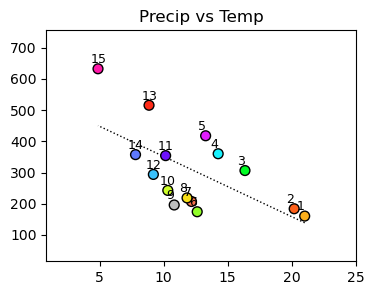

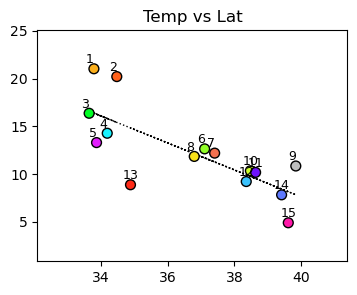

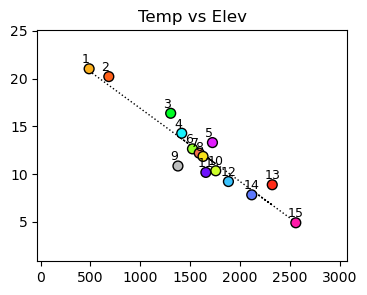

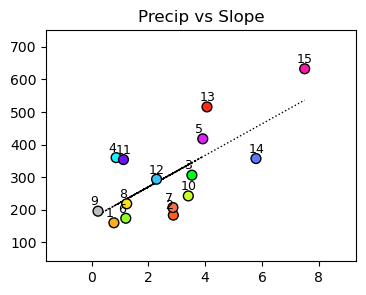

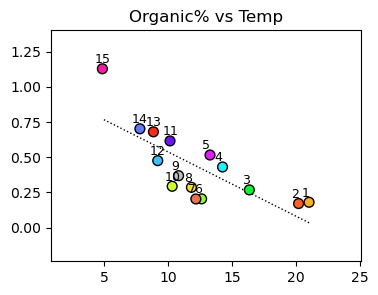

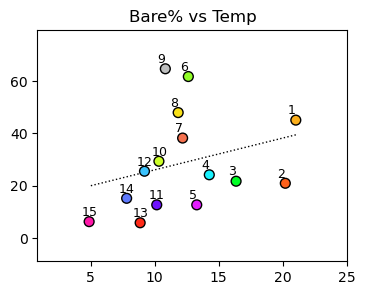

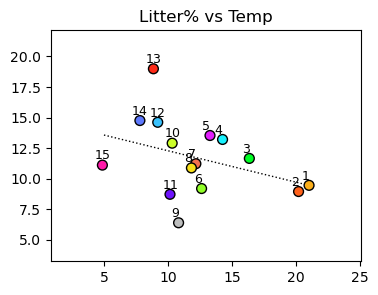

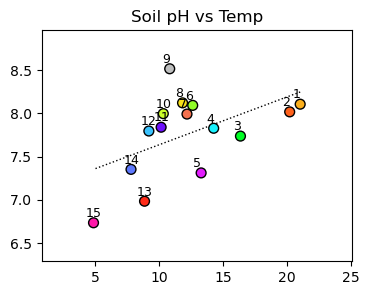

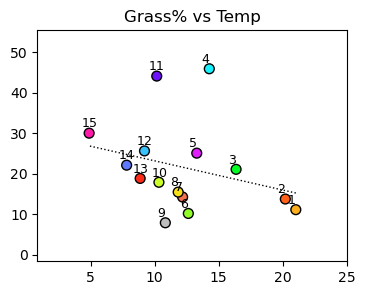

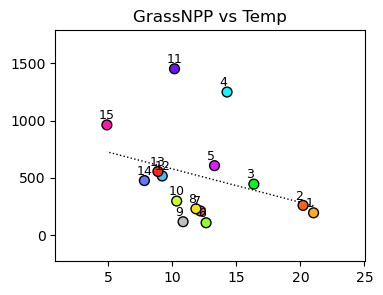

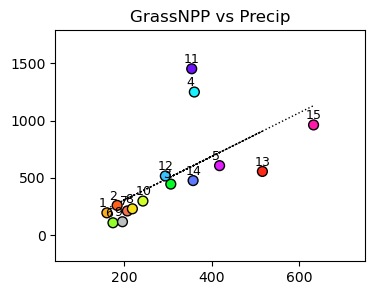

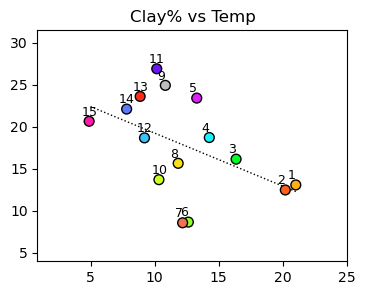

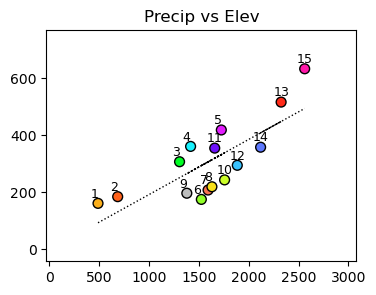

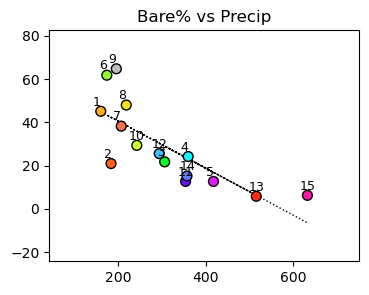

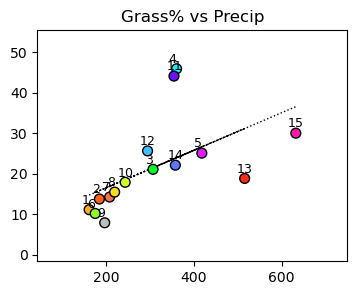

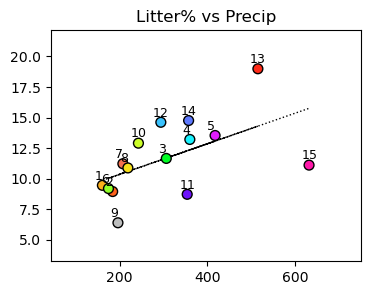

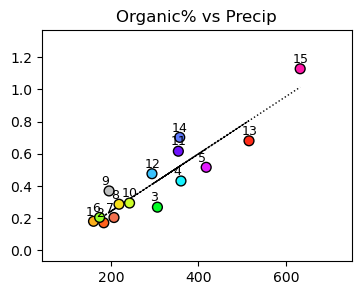

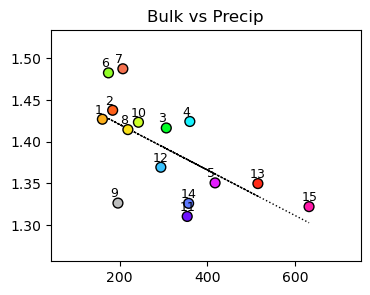

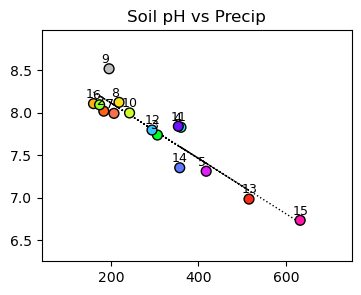

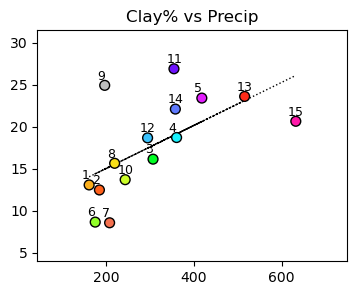

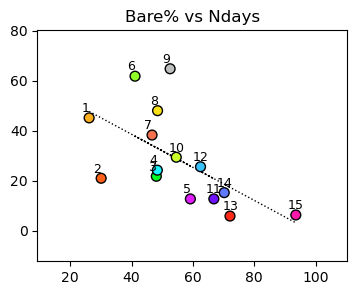

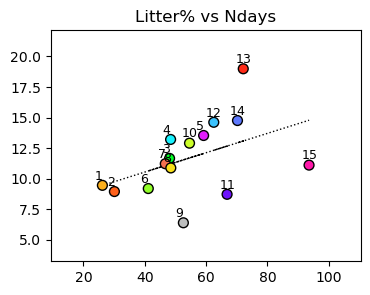

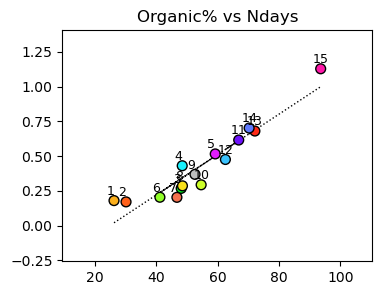

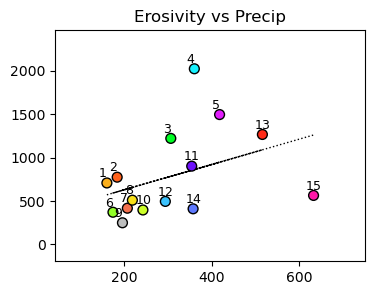

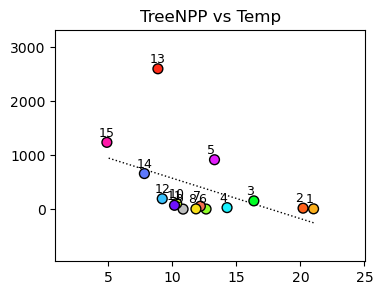

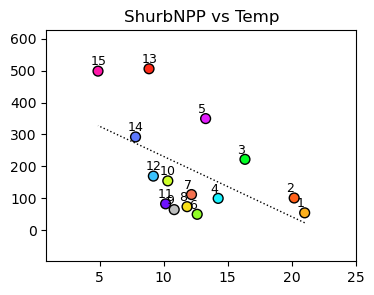

In [28]:
#ZONAL CORRELATION PLOTS

#########################################################################################

x = df['tavg']
y = df['accm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Precip vs Temp')
plot_fn()

#########################################################################################

x = df['ylat']
y = df['tavg']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Temp vs Lat')
plot_fn()

#########################################################################################

x = df['elev']
y = df['tavg']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Temp vs Elev')
plot_fn()

#########################################################################################

x = df['slpe']
y = df['accm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Precip vs Slope')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['orgm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Organic% vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['bare']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Bare% vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['litr']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Litter% vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['pphh']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Soil pH vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['gras']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Grass% vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['graN']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('GrassNPP vs Temp')
plot_fn()

#########################################################################################

x = df['accm']
y = df['graN']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('GrassNPP vs Precip')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['clay']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Clay% vs Temp')
plot_fn()

#########################################################################################

x = df['elev']
y = df['accm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Precip vs Elev')
plot_fn()

#########################################################################################

x = df['accm']
y = df['bare']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Bare% vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['gras']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Grass% vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['litr']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Litter% vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['orgm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Organic% vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['bulk']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Bulk vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['pphh']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Soil pH vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['clay']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Clay% vs Precip')
plot_fn()

#########################################################################################

x = df['nday']
y = df['bare']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Bare% vs Ndays')
plot_fn()

#########################################################################################

x = df['nday']
y = df['litr']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Litter% vs Ndays')
plot_fn()

#########################################################################################

x = df['nday']
y = df['orgm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Organic% vs Ndays')
plot_fn()

#########################################################################################

x = df['accm']
y = df['eroR']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Erosivity vs Precip')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['tree']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('TreeNPP vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['shrN']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('ShurbNPP vs Temp')
plot_fn()



### Itemized list of % area of ecoregions in iso classes

In [9]:

import pandas as pd

arcpy.env.workspace = gdbDIR

arcpy.conversion.ExportTable(
  in_table='us_eco_l3_clip',
  out_table=os.path.join(projDIR, 'us_eco_l3_clip.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.conversion.ExportTable(
  in_table='us_eco_l4_clip',
  out_table=os.path.join(projDIR, 'us_eco_l4_clip.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

df = pd.read_csv(os.path.join(projDIR, 'Zonal', 'Zonal_eco3.csv'))
total_n = df.iloc[:, 1:].sum().sum()
eco_df = pd.read_csv(os.path.join(projDIR, 'us_eco_l3_clip.csv'))
ecoid_econame_key = dict(zip(eco_df['US_L3CODE'].tolist(), eco_df['US_L3NAME'].tolist()))
for i, row in df.iterrows():
  print('Class Num: ', i+1)
  row_n = row[1:].sum()
  sorted_row = row[1:].sort_values(ascending=False)
  top_three = sorted_row[:3].divide(row_n).multiply(100.0)
  top_index = top_three.index
  for j, eco_id in enumerate(top_index):
    print(top_three[j], ecoid_econame_key[int(eco_id.split('_')[-1])])
    pass

df = pd.read_csv(os.path.join(projDIR, 'Zonal', 'Zonal_eco4.csv'))
total_n = df.iloc[:, 1:].sum().sum()
eco_df = pd.read_csv(os.path.join(projDIR, 'us_eco_l4_clip.csv'))
ecoid_econame_key = dict(zip(eco_df['US_L4CODE'].tolist(), eco_df['US_L4NAME'].tolist()))
for i, row in df.iterrows():
  #print('Class Num: ', i+1)
  row_n = row[1:].sum()
  sorted_row = row[1:].sort_values(ascending=False)
  top_five = sorted_row[:5].divide(row_n).multiply(100.0)
  top_index = top_five.index
  for j, eco_id in enumerate(top_index):
    #print(top_five[j], ecoid_econame_key[eco_id.split('_')[-1]])
    pass


Class Num:  1
38.04846363901482 Central Basin and Range
28.270897955937325 Arizona/New Mexico Plateau
23.433813197592727 Colorado Plateaus
Class Num:  2
38.18975210703859 Central Basin and Range
31.907321249883946 Colorado Plateaus
21.227188792721048 Arizona/New Mexico Plateau
Class Num:  3
58.62554937311438 Sonoran Basin and Range
40.25534757962647 Mojave Basin and Range
0.42175152154168966 Arizona/New Mexico Plateau
Class Num:  4
73.42319092772559 Sonoran Basin and Range
26.370352892598547 Mojave Basin and Range
0.10322808983793191 Chihuahuan Deserts
Class Num:  5
37.6173142861166 Arizona/New Mexico Plateau
27.50557968922715 Central Basin and Range
19.65669949941211 Colorado Plateaus
Class Num:  6
59.63303284826181 Central Basin and Range
18.099340016368988 Colorado Plateaus
17.629166981082793 Arizona/New Mexico Plateau
Class Num:  7
91.45617993885573 Central Basin and Range
4.693186781190858 Arizona/New Mexico Plateau
1.2920366865628186 Colorado Plateaus
Class Num:  8
26.26537845612

C:\Users\andre\AppData\Local\Temp\ipykernel_17664\3423522940.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(top_three[j], ecoid_econame_key[int(eco_id.split('_')[-1])])


### Plot PCA loading

{1: 'accm_1974_2013', 2: 'CCSM4_1974_2013_ero', 3: 'CCSM4_1974_2013_ndays', 4: 'DEM_Elev', 5: 'DEM_Slope', 6: 'POL_bd', 7: 'POL_ksat', 8: 'POL_om', 9: 'POL_ph', 10: 'POL_sand', 11: 'RAP_afgNPP', 12: 'RAP_bgr', 13: 'RAP_ltr', 14: 'RAP_pfgNPP', 15: 'RAP_shrNPP', 16: 'RAP_treNPP', 17: 'tmomn_1974_2013'}


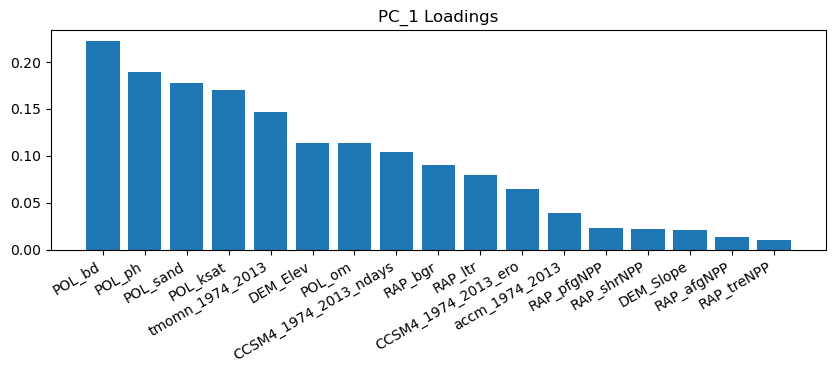

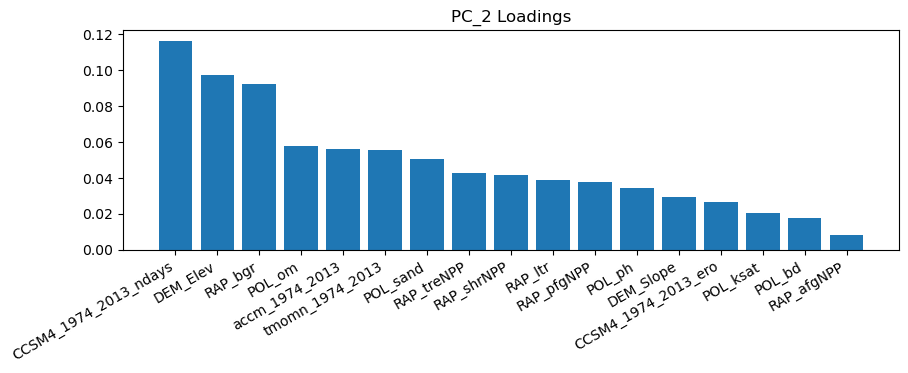

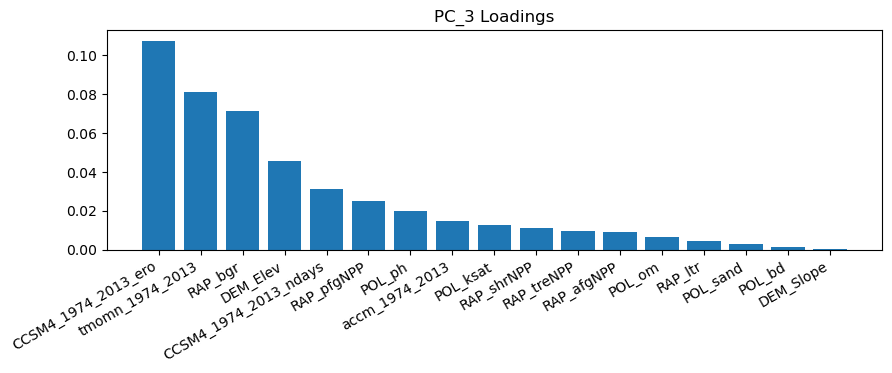

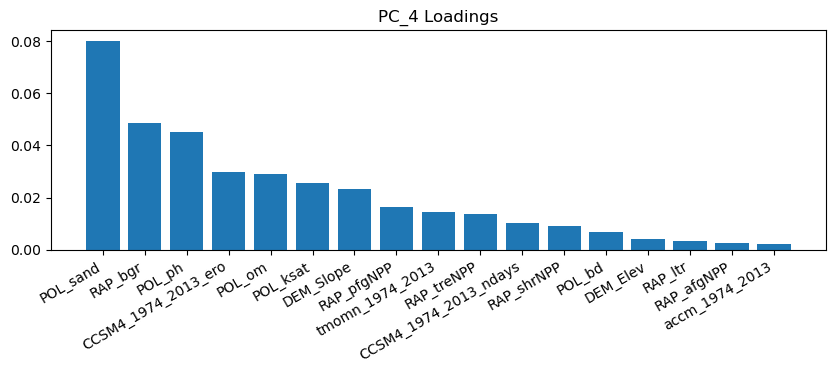

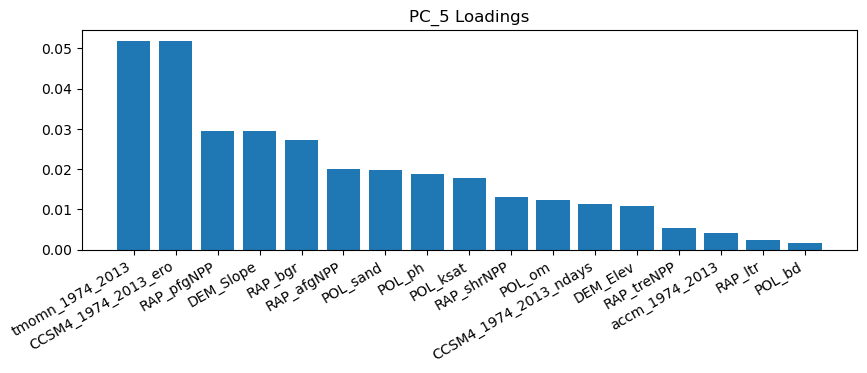

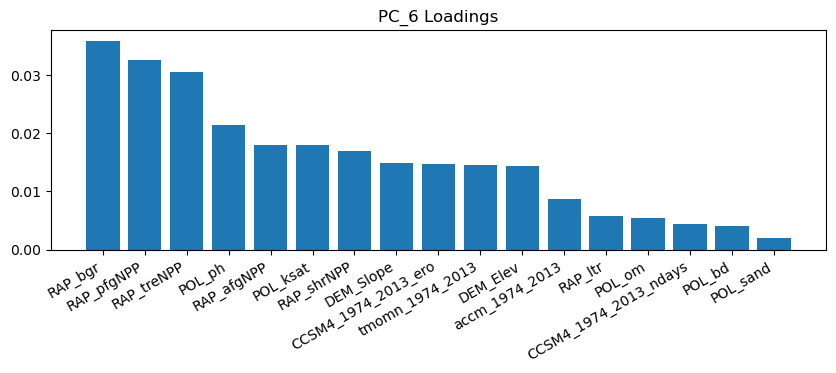

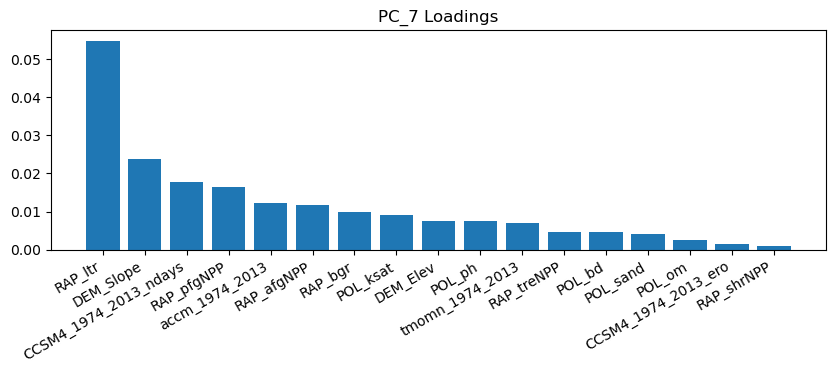

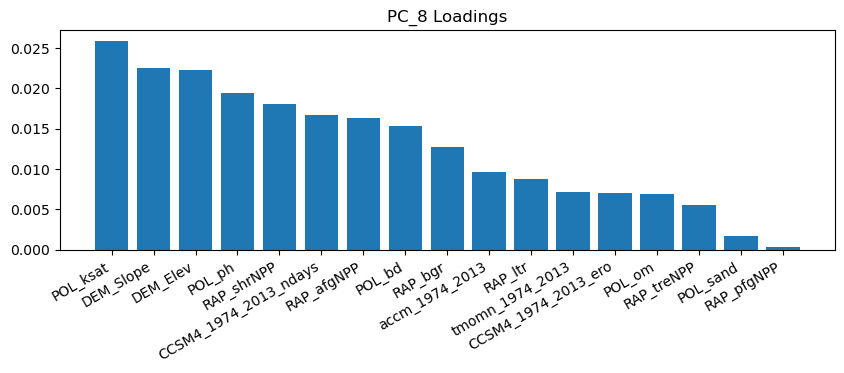

In [15]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

df = pd.read_csv(os.path.join(projDIR, 'MultidimRasterLyr_d_loading.csv'))

#ZeroOne n=8, Zscore n=12
num_comps = 8

print(varidx_varlbl_key)

for i in range(num_comps):
  col_str = 'PC_{}'.format(i+1)
  sorted_df = df.sort_values(by=col_str, key=abs, ascending=False)
  sorted_idx = [x+1 for x in sorted_df.index.to_list()]
  x_labels = [varidx_varlbl_key[sorted_idx[j]] for j in range(len(sorted_idx))]
  y = sorted_df[col_str].to_list()
  y_abs = [abs(n) for n in y]
  fig, ax = plt.subplots(figsize=(8.5, 3))
  ax.tick_params(axis='x', labelrotation=45)
  fig.tight_layout()
  fig.autofmt_xdate()
  ax.set_title('PC_{} '.format(i+1) + 'Loadings')
  ax.bar(x_labels, y_abs)
  

### Create dendrogram

In [11]:

arcpy.env.workspace = projDIR

arcpy.sa.Dendrogram(
  in_signature_file='iso_signature.gsg', 
  out_dendrogram_file='dendro.txt', 
  distance_calculation='VARIANCE', 
  line_width=''
)


<Result 'C:\\Users\\andre\\Documents\\ArcGIS\\Projects\\MyProject\\dendro.txt'>

### Train ISO Cluster Classification Tool, outputs a ecd definition file

In [13]:

arcpy.env.workspace = gdbDIR

arcpy.sa.TrainIsoClusterClassifier(
  in_raster='Extract_Composite',
  max_classes='15',
  out_classifier_definition=os.path.join(projDIR, 'definitions.ecd'),
  min_samples_per_cluster=250,
  used_attributes='COLOR;MEAN;STD;COUNT;COMPACTNESS;RECTANGULARITY'
)
    

<Result 'C:\\Users\\fullh\\Documents\\ArcGIS\\Projects\\MyProject\\definitions.ecd'>

### Iso Cluster PCA with test cluster numbers

In [7]:
import random

if not os.path.exists(os.path.join(projDIR, 'IsoCluster_Test')):
  os.makedirs(os.path.join(projDIR, 'IsoCluster_Test'))

#if not os.path.exists(os.path.join(projDIR, 'PCA_Test')):
#  os.makedirs(os.path.join(projDIR, 'PCA_Test'))

threedigits = [str(x) for x in random.sample(range(0, 10), 4)]

arcpy.env.workspace = gdbDIR

#test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

arcpy.md.RasterToNetCDF(
  in_raster='Extract_Composite',
  out_netCDF_file=os.path.join(projDIR, 'RasterToNetCD' + ''.join(threedigits) + '.nc'),
  variable='Extract_Composite',
  variable_units='',
  x_dimension='lon',
  y_dimension='lat',
  band_dimension='band',
  fields_to_dimensions=None,
  compression_level=0
)

arcpy.md.MakeMultidimensionalRasterLayer(
  in_multidimensional_raster=os.path.join(projDIR, 'RasterToNetCD' + ''.join(threedigits) + '.nc'),
  out_multidimensional_raster_layer='MultidimRasterLyr' + ''.join(threedigits),
  variables='Extract_Composite',
  dimension_def='ALL',
  dimension_ranges=None,
  dimension_values=None,
  dimension='',
  start_of_first_iteration='',
  end_of_first_iteration='',
  iteration_step=None,
  iteration_unit='',
  template='-120.00833328533 31.3333333207995 -102.991666625469 42.00833331653 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]',
  dimensionless='DIMENSIONS',
  spatial_reference=None
)

arcpy.ia.MultidimensionalPrincipalComponents(
  in_multidimensional_raster='MultidimRasterLyr' + ''.join(threedigits),
  mode='DIMENSION_REDUCTION',
  dimension='band',
  out_pc=os.path.join(projDIR, 'MultidimRasterLyr_d_pc.crf'),
  out_loadings='MultidimRasterLyr_d_loading.csv',
  out_eigenvalues=os.path.join(gdbDIR, 'eigenvalues'),
  variable='Extract_Composite',
  number_of_pc='95%'
)

arcpy.CopyRaster_management(os.path.join(projDIR, 'MultidimRasterLyr_d_pc.crf'), os.path.join(projDIR, 'MultidimRasterLyr_d_pc.tif'))

for n in test_cluster_sizes:

  print(n)
    
  with arcpy.EnvManager(scratchWorkspace=gdbDIR):
    out_raster = arcpy.sa.IsoClusterUnsupervisedClassification(
      in_raster_bands=os.path.join(projDIR, 'MultidimRasterLyr_d_pc.crf'),
      Number_of_classes=n,
      Minimum_class_size=100,
      Sample_interval=10,
      out_signature_file=os.path.join(projDIR, 'IsoCluster_Test', 'iso_signature_{}.gsg'.format(n))
    )

  with arcpy.EnvManager(scratchWorkspace=gdbDIR):
    out_raster = arcpy.sa.MajorityFilter(
      in_raster=out_raster,
      number_neighbors='FOUR',
      majority_definition='MAJORITY'
    )

  # with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  #   out_raster = arcpy.sa.BoundaryClean(
  #     in_raster=out_raster,
  #     sort_type='NO_SORT',
  #     number_of_runs='TWO_WAY'
  #   )

  with arcpy.EnvManager(scratchWorkspace=gdbDIR):
    output_raster = arcpy.sa.ExtractByMask(
      in_raster=out_raster,
      in_mask_data='clip_shape',
      extraction_area='INSIDE',
      analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
    )
  output_raster.save('IsoCluster')
    
  del output_raster
  arcpy.CopyRaster_management('IsoCluster', os.path.join(projDIR, 'IsoCluster_Test', 'IsoCluster_{}.tif'.format(n)))


print('DONE')


2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
DONE


### Zonal stats for ecoregion level 3 for test cluster numbers

In [8]:
if not os.path.exists(os.path.join(projDIR, 'Zonal3_Test')):
  os.makedirs(os.path.join(projDIR, 'Zonal3_Test'))

arcpy.env.workspace = gdbDIR

#test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

for n in test_cluster_sizes:

  print(n)
    
  arcpy.sa.ZonalHistogram(
    in_zone_data='us_eco_l3_clip',
    zone_field='US_L3CODE',
    in_value_raster=os.path.join(projDIR, 'IsoCluster_Test', 'IsoCluster_{}.tif'.format(n)),
    out_table='Zonal_eco3_{}'.format(n),
    out_graph='',
    zones_as_rows='ZONES_AS_FIELDS'
  )

  arcpy.conversion.ExportTable(
    in_table='Zonal_eco3_{}'.format(n),
    out_table=os.path.join(projDIR, 'Zonal3_Test', 'Zonal_eco3_{}.csv'.format(n)),
    where_clause='',
    use_field_alias_as_name='NOT_USE_ALIAS',
    sort_field=None
  )

  arcpy.management.Delete('Zonal_eco3_{}'.format(n))

print('DONE')


2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
DONE


### Zonal stats for ecoregion level 4 for test cluster numbers

In [9]:
if not os.path.exists(os.path.join(projDIR, 'Zonal4_Test')):
  os.makedirs(os.path.join(projDIR, 'Zonal4_Test'))

arcpy.env.workspace = gdbDIR

#test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

for n in test_cluster_sizes:

  print(n)
    
  arcpy.sa.ZonalHistogram(
    in_zone_data='us_eco_l4_clip',
    zone_field='US_L4CODE',
    in_value_raster=os.path.join(projDIR, 'IsoCluster_Test', 'IsoCluster_{}.tif'.format(n)),
    out_table='Zonal_eco4_{}'.format(n),
    out_graph='',
    zones_as_rows='ZONES_AS_FIELDS'
  )

  arcpy.conversion.ExportTable(
    in_table='Zonal_eco4_{}'.format(n),
    out_table=os.path.join(projDIR, 'Zonal4_Test', 'Zonal_eco4_{}.csv'.format(n)),
    where_clause='',
    use_field_alias_as_name='NOT_USE_ALIAS',
    sort_field=None
  )

  arcpy.management.Delete('Zonal_eco4_{}'.format(n))

print('DONE')


2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
DONE


### Zonal stats for MLRAs

In [10]:
if not os.path.exists(os.path.join(projDIR, 'ZonalM_Test')):
  os.makedirs(os.path.join(projDIR, 'ZonalM_Test'))

arcpy.env.workspace = gdbDIR

#test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

for n in test_cluster_sizes:

  print(n)
    
  arcpy.sa.ZonalHistogram(
    in_zone_data='us_eco_mlra_clip',
    zone_field='MLRA_ID',
    in_value_raster=os.path.join(projDIR, 'IsoCluster_Test', 'IsoCluster_{}.tif'.format(n)),
    out_table='Zonal_mlra_{}'.format(n),
    out_graph='',
    zones_as_rows='ZONES_AS_FIELDS'
  )

  arcpy.conversion.ExportTable(
    in_table='Zonal_mlra_{}'.format(n),
    out_table=os.path.join(projDIR, 'ZonalM_Test', 'Zonal_mlra_{}.csv'.format(n)),
    where_clause='',
    use_field_alias_as_name='NOT_USE_ALIAS',
    sort_field=None
  )

  arcpy.management.Delete('Zonal_mlra_{}'.format(n))

print('DONE')


2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
DONE


### ZeroOne Eco3 binary images of color groups

In [6]:
if not os.path.exists(os.path.join(projDIR, 'Binary_Images')):
  os.makedirs(os.path.join(projDIR, 'Binary_Images'))

arcpy.env.workspace = gdbDIR

def clip_fn(i_raster):
  with arcpy.EnvManager(scratchWorkspace=gdbDIR):
    o_raster = arcpy.sa.ExtractByMask(
      in_raster=i_raster,
      in_mask_data='clip_shape',
      extraction_area='INSIDE',
      analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
    )
  return o_raster
    
#GROUP 125671012
#US_L3CODE: 13, 20, 22, 24
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==1)|(raster==2)|(raster==5)|(raster==6)|(raster==7)|(raster==10)|(raster==12),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'eco3_125671012.tif'))

#GROUP 34
#US_L3CODE: 14, 81
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==3)|(raster==4),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'eco3_34.tif'))

#GROUP 81315
#US_L3CODE: 21, 23, 79
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==8)|(raster==13)|(raster==15),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'eco3_81315.tif'))

#GROUP 91012
#US_L3CODE: 25, 26
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==9)|(raster==10)|(raster==12),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'eco3_91012.tif'))

#GROUP 101114
#US_L3CODE: 5, 18, 19, 80
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==10)|(raster==11)|(raster==14),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'eco3_101114.tif'))

del output_raster

print('DONE')


DONE


### ZeroOne Eco3 zonal stats for prediction accuracy of color group binary images

In [7]:
if not os.path.exists(os.path.join(projDIR, 'Binary_Test')):
  os.makedirs(os.path.join(projDIR, 'Binary_Test'))

arcpy.env.workspace = gdbDIR

#GROUP 125671012
#US_L3CODE: 13, 20, 22, 24
#GROUP 34
#US_L3CODE: 14, 81
#GROUP 81315
#US_L3CODE: 21, 23, 79
#GROUP 91012
#US_L3CODE: 25, 26
#GROUP 101114
#US_L3CODE: 5, 18, 19, 80

for n in ['125671012', '34', '81315', '91012', '101114']:
  arcpy.sa.ZonalHistogram(
    in_zone_data='us_eco_l3_clip',
    zone_field='US_L3CODE',
    in_value_raster=os.path.join(projDIR, 'Binary_Images', 'eco3_{}.tif'.format(n)),
    out_table='Zonal_eco3_{}'.format(n),
    out_graph='',
    zones_as_rows='ZONES_AS_FIELDS'
  )

  arcpy.conversion.ExportTable(
    in_table='Zonal_eco3_{}'.format(n),
    out_table=os.path.join(projDIR, 'Binary_Test', 'Zonal_eco3_{}.csv'.format(n)),
    where_clause='',
    use_field_alias_as_name='NOT_USE_ALIAS',
    sort_field=None
  )

  arcpy.management.Delete('Zonal_eco3_{}'.format(n))

print('DONE')

DONE


### ZeroOne MLRA binary images of color groups

In [8]:
if not os.path.exists(os.path.join(projDIR, 'Binary_Images')):
  os.makedirs(os.path.join(projDIR, 'Binary_Images'))

arcpy.env.workspace = gdbDIR

def clip_fn(i_raster):
  with arcpy.EnvManager(scratchWorkspace=gdbDIR):
    o_raster = arcpy.sa.ExtractByMask(
      in_raster=i_raster,
      in_mask_data='clip_shape',
      extraction_area='INSIDE',
      analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
    )
  return o_raster

#GROUP 125678
#MLRA_ID: 24, 27, 28A, 28B, 29, 34A, 34B, 35, 42B
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==1)|(raster==2)|(raster==5)|(raster==6)|(raster==7)|(raster==8),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'mlra_125678.tif'))


#GROUP 34
#MLRA_ID: 32, 40
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==3)|(raster==4),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'mlra_34.tif'))


#GROUP 813
#MLRA_ID: 38, 41
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==8)|(raster==13),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'mlra_813.tif'))


#GROUP 912
#MLRA_ID: 42A, 42C, 70A, 70B, 77B, 77C, 77D, 77E
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==9)|(raster==12),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'mlra_912.tif'))


#GROUP 101114
#MLRA_ID: 11, 13, 22A, 23, 25, 26, 36, 46, 47, 48A, 51
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==10)|(raster==11)|(raster==14),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'mlra_101114.tif'))


#GROUP 15
#MLRA_ID: 39
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==15),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'mlra_15.tif'))

del output_raster

print('DONE')


DONE


### ZeroOne MLRA zonal stats for prediction accuracy of color group binary images

In [9]:
if not os.path.exists(os.path.join(projDIR, 'Binary_Test')):
  os.makedirs(os.path.join(projDIR, 'Binary_Test'))

arcpy.env.workspace = gdbDIR

#GROUP 125678
#MLRA_ID: 24, 27, 28A, 28B, 29, 34A, 34B, 35, 42B
#GROUP 34
#MLRA_ID: 30, 40
#GROUP 813
#MLRA_ID: 38, 41
#GROUP 912
#MLRA_ID: 42A, 42C, 70A, 70B, 77B, 77C, 77D, 77E
#GROUP 101114
#MLRA_ID: 11, 13, 22A, 23, 25, 26, 36, 46, 47, 48A, 51
#GROUP 15
#MLRA_ID: 39

for n in ['125678', '34', '813', '912', '101114', '15']:
  arcpy.sa.ZonalHistogram(
    in_zone_data='us_eco_mlra_clip',
    zone_field='MLRARSYM',
    in_value_raster=os.path.join(projDIR, 'Binary_Images', 'mlra_{}.tif'.format(n)),
    out_table='Zonal_mlra_{}'.format(n),
    out_graph='',
    zones_as_rows='ZONES_AS_FIELDS'
  )

  arcpy.conversion.ExportTable(
    in_table='Zonal_mlra_{}'.format(n),
    out_table=os.path.join(projDIR, 'Binary_Test', 'Zonal_mlra_{}.csv'.format(n)),
    where_clause='',
    use_field_alias_as_name='NOT_USE_ALIAS',
    sort_field=None
  )

  arcpy.management.Delete('Zonal_mlra_{}'.format(n))

print('DONE')

DONE


### Zscore Eco3 binary images of color groups

In [13]:
if not os.path.exists(os.path.join(projDIR, 'Binary_Images')):
  os.makedirs(os.path.join(projDIR, 'Binary_Images'))

arcpy.env.workspace = gdbDIR

def clip_fn(i_raster):
  with arcpy.EnvManager(scratchWorkspace=gdbDIR):
    o_raster = arcpy.sa.ExtractByMask(
      in_raster=i_raster,
      in_mask_data='clip_shape',
      extraction_area='INSIDE',
      analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
    )
  return o_raster

#GROUP 134
#US_L3CODE: 14, 81
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==1)|(raster==3)|(raster==4),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'eco3_134.tif'))

#GROUP 2567812
#US_L3CODE: 13, 18, 20, 22, 24
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==2)|(raster==5)|(raster==6)|(raster==7)|(raster==8)|(raster==12),1,0)'
  )
    
output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'eco3_2567812.tif'))

#GROUP 91115
#US_L3CODE: 23, 79
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==9)|(raster==11)|(raster==15),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'eco3_91115.tif'))

#GROUP 9121314
#US_L3CODE: 5, 19, 21, 80
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==9)|(raster==12)|(raster==13)|(raster==14),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'eco3_9121314.tif'))

#GROUP 10
#US_L3CODE: 25, 26
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==9)|(raster==10)|(raster==12),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'eco3_10.tif'))

del output_raster

print('DONE')


DONE


### Zscore Eco3 zonal stats for prediction accuracy of color group binary images

In [14]:
if not os.path.exists(os.path.join(projDIR, 'Binary_Test')):
  os.makedirs(os.path.join(projDIR, 'Binary_Test'))

arcpy.env.workspace = gdbDIR

#GROUP 134
#US_L3CODE: 14, 81
#GROUP 2567812
#US_L3CODE: 13, 18, 20, 22, 24
#GROUP 91115
#US_L3CODE: 23, 79
#GROUP 9121314
#US_L3CODE: 5, 19, 21, 80
#GROUP 10
#US_L3CODE: 25, 26

for n in ['134', '2567812', '91115', '9121314', '10']:
  arcpy.sa.ZonalHistogram(
    in_zone_data='us_eco_l3_clip',
    zone_field='US_L3CODE',
    in_value_raster=os.path.join(projDIR, 'Binary_Images', 'eco3_{}.tif'.format(n)),
    out_table='Zonal_eco3_{}'.format(n),
    out_graph='',
    zones_as_rows='ZONES_AS_FIELDS'
  )

  arcpy.conversion.ExportTable(
    in_table='Zonal_eco3_{}'.format(n),
    out_table=os.path.join(projDIR, 'Binary_Test', 'Zonal_eco3_{}.csv'.format(n)),
    where_clause='',
    use_field_alias_as_name='NOT_USE_ALIAS',
    sort_field=None
  )

  arcpy.management.Delete('Zonal_eco3_{}'.format(n))

print('DONE')

DONE


### Zscore MLRA binary images of color groups

In [15]:
if not os.path.exists(os.path.join(projDIR, 'Binary_Images')):
  os.makedirs(os.path.join(projDIR, 'Binary_Images'))

arcpy.env.workspace = gdbDIR

def clip_fn(i_raster):
  with arcpy.EnvManager(scratchWorkspace=gdbDIR):
    o_raster = arcpy.sa.ExtractByMask(
      in_raster=i_raster,
      in_mask_data='clip_shape',
      extraction_area='INSIDE',
      analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
    )
  return o_raster

#GROUP 13
#MLRA_ID: 30, 40
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==1)|(raster==3),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'mlra_13.tif'))

#GROUP 24568
#MLRA_ID: 24, 26, 27, 28A, 29, 34B, 35, 42B
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==2)|(raster==4)|(raster==5)|(raster==6)|(raster==8),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'mlra_24568.tif'))

#GROUP 7912
#MLRA_ID: 11, 13, 23, 25, 28B, 34A, 36, 39, 51
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==7)|(raster==9)|(raster==12),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'mlra_7912.tif'))

#GROUP 10
#MLRA_ID: 42A, 42C, 70A, 70B, 77B, 77C, 77D, 77E
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==10),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'mlra_10.tif'))

#GROUP 11
#MLRA_ID: 38, 41
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==11),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'mlra_11.tif'))

#GROUP 1314
#MLRA_ID: 22A, 46, 47, 48A
with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['IsoCluster'],
    input_names=['raster'],
    expression='Con((raster==13)|(raster==14),1,0)'
  )

output_raster = clip_fn(output_raster)
output_raster.save(os.path.join(projDIR, 'Binary_Images', 'mlra_1314.tif'))

del output_raster

print('DONE')


DONE


### Zscore MLRA zonal stats for prediction accuracy of color group binary images

In [16]:
if not os.path.exists(os.path.join(projDIR, 'Binary_Test')):
  os.makedirs(os.path.join(projDIR, 'Binary_Test'))

arcpy.env.workspace = gdbDIR

#GROUP 13
#MLRA_ID: 30, 40
#GROUP 24568
#MLRA_ID: 24, 26, 27, 28A, 29, 34B, 35, 42B
#GROUP 7912
#MLRA_ID: 11, 13, 23, 25, 28B, 34A, 36, 39, 51
#GROUP 10
#MLRA_ID: 42A, 42C, 70A, 70B, 77B, 77C, 77D, 77E
#GROUP 11
#MLRA_ID: 38, 41
#GROUP 1314
#MLRA_ID: 22A, 46, 47, 48A

for n in ['13', '24568', '7912', '10', '11', '1314']:
  arcpy.sa.ZonalHistogram(
    in_zone_data='us_eco_mlra_clip',
    zone_field='MLRARSYM',
    in_value_raster=os.path.join(projDIR, 'Binary_Images', 'mlra_{}.tif'.format(n)),
    out_table='Zonal_mlra_{}'.format(n),
    out_graph='',
    zones_as_rows='ZONES_AS_FIELDS'
  )

  arcpy.conversion.ExportTable(
    in_table='Zonal_mlra_{}'.format(n),
    out_table=os.path.join(projDIR, 'Binary_Test', 'Zonal_mlra_{}.csv'.format(n)),
    where_clause='',
    use_field_alias_as_name='NOT_USE_ALIAS',
    sort_field=None
  )

  arcpy.management.Delete('Zonal_mlra_{}'.format(n))

print('DONE')

DONE
